# Import libraries/Data

In [1]:
import os
import warnings
import sys
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata
import scvi
import scanpy as sc

sc.logging.print_version_and_date()
sc.logging.print_header()

Running Scanpy 1.7.2, on 2021-08-09 15:00.
scanpy==1.7.2 anndata==0.7.5 umap==0.4.6 numpy==1.21.0 scipy==1.5.2 pandas==1.2.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.7.1 louvain==0.7.0 leidenalg==0.8.3


In [2]:
adata = sc.read_h5ad('/mnt/ibm_lg/shoshana/trachasp/SZPreprocess_removesamples.h5ad')

In [3]:
def run_scvi(
    adata,
    n_latent=50,
    n_layers=3,
    dropout_rate=0.1,
    dispersion="gene",
    max_epochs=None,
    batch_size=1024,
    pretrained_scvi_path=None,
    var_subset_type="inner_join",
    obsm_latent_key="X_scvi",
    save_folder=None,
    overwrite=True,
    save_anndata=False,
):
    training_mode = adata.uns["_training_mode"]
    if training_mode == "online" and pretrained_scvi_path is None:
        raise ValueError("online training but no pretrained_scvi_path passed in.")

    if training_mode == "offline":
        model = scvi.model.SCVI(
            adata,
            n_latent=n_latent,
            n_layers=n_layers,
            dropout_rate=dropout_rate,
            dispersion=dispersion,
            use_layer_norm="both",
            use_batch_norm="none",
            encode_covariates=True,
        )
        print("Training scvi offline.")

    elif training_mode == "online":
        if max_epochs is None:
            n_cells = adata.n_obs
            max_epochs = np.min([round((20000 / n_cells) * 200), 200])

        query = adata[adata.obs["_dataset"] == "query"].copy()
        model = scvi.model.SCVI.load_query_data(query, pretrained_scvi_path)
        print("Training scvi online.")

    model.train(max_epochs=max_epochs, train_size=1.0, batch_size=batch_size)
    adata.obsm[obsm_latent_key] = model.get_latent_representation(adata)
    
    sc.pp.neighbors(adata, use_rep=obsm_latent_key)
    sc.tl.umap(adata)
    adata.obsm[obsm_latent_key+'_umap'] = adata.obsm['X_umap']
    del adata.obsm['X_umap']
    
    if save_folder is not None:
        model.save(save_folder, overwrite=overwrite, save_anndata=save_anndata)


In [4]:
adata

AnnData object with n_obs × n_vars = 12197 × 33534
    obs: 'Identity', 'Patient', 'batch', 'VAP', 'Time', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'percent_mito', 'percent_ribo', 'percent_SARS', 'n_genes', 'n_counts'
    var: 'feature_types', 'gene_ids-0-0', 'gene_ids-1-0', 'gene_ids-2-0', 'gene_ids-3-0', 'gene_ids-4-0', 'gene_ids-5-0', 'gene_ids-6-0', 'gene_ids-7-0', 'gene_ids-8-0', 'gene_ids-9-0', 'gene_ids-1', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'Identity_colors'
    layers: 'raw_counts'

In [5]:
scvi.data.setup_anndata(
    adata, batch_key="Identity", layer="raw_counts"
)
adata.uns["_training_mode"] = 'offline'

INFO     Using batches from adata.obs["Identity"]                                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["raw_counts"]                                          
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 12197 cells, 33534 vars, 18       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [6]:
run_scvi(
    adata,
    max_epochs=100,
    n_latent=50,
    dropout_rate=0.1,
    dispersion = "gene-batch",
    obsm_latent_key = 'X_scvi',
    save_folder="scvi_batch_correction"
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training scvi offline.
Epoch 100/100: 100%|██████████| 100/100 [04:16<00:00,  2.57s/it, loss=5.84e+03, v_num=1]


/data/shoshana/anaconda3/lib/python3.8/site-packages/umap/spectral.py:340: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


In [7]:
adata.obsm['X_umap'] = adata.obsm['X_scvi_umap']

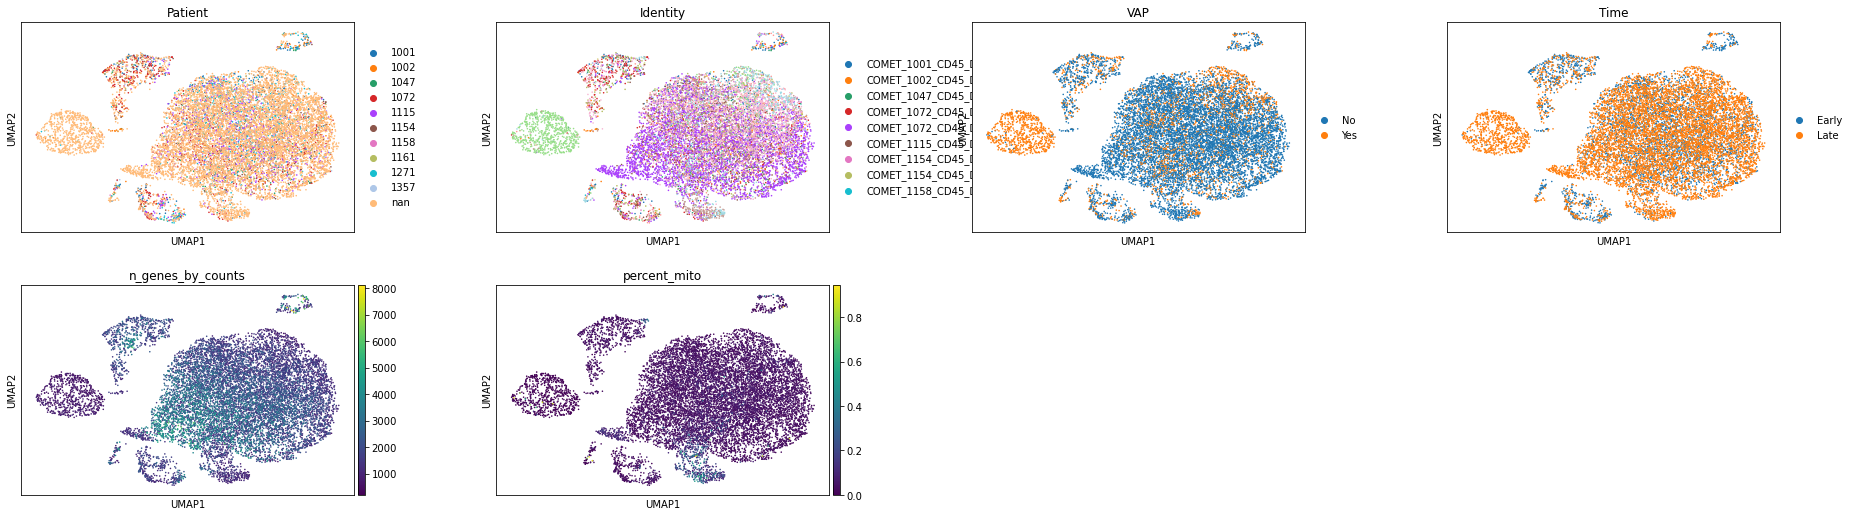

In [8]:
sc.pl.umap(adata, color=['Patient', 'Identity', 'VAP', 'Time', 'n_genes_by_counts', 'percent_mito'],wspace=0.3)

In [26]:
### writing h5ad 
adata.write_h5ad('/mnt/ibm_lg/shoshana/trachasp/adata_scVI_samplesremoved_epoch100.h5ad')